In [ ]:
import numpy as np
import yfinance as yf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

**Expliquer ce qu'on veut faire: la problématique etc...***

In [ ]:

import requests

# URL for downloading the ECB speeches CSV
csv_url = "https://www.ecb.europa.eu/press/key/shared/data/all_ECB_speeches.csv?e71dfd40f5555777ae06473522d191b4"

# Send a GET request to download the file
response = requests.get(csv_url)


if response.status_code == 200:
    # Save the CSV content to a file
    with open('ecb_speeches.csv', 'wb') as file:
        file.write(response.content)
    print("Download successful, saved as 'ecb_speeches.csv'")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")
speeches = pd.read_csv("ecb_speeches.csv", header=0, sep='|')

Download successful, saved as 'ecb_speeches.csv'


In [ ]:

speeches = speeches[speeches['date'] <= '2024-10-30'].reset_index(drop=True).dropna() # the database is continously updated, so we restrain our analysis at dates previous to 30/10/2024

In [ ]:
speeches

,date,speakers,title,subtitle,contents
1,2024-10-28,Frank Elderson,Transcript of video recording for Finance and ...,"Contribution by Frank Elderson, Member of the ...",SPEECH Transcript of video recording for Fi...
2,2024-10-28,Luis de Guindos,Monetary policy and financial stability in the...,"Introductory remarks by Luis de Guindos, Vice-...",SPEECH Monetary policy and financial stabil...
3,2024-10-25,Christine Lagarde,IMFC Statement,"Statement by Christine Lagarde, President of t...",SPEECH IMFC Statement Statement by Chris...
4,2024-10-24,Philip R. Lane,Underlying inflation: an update,"Speech by Philip R. Lane, Member of the Execut...",SPEECH Underlying inflation: an update Sp...
7,2024-10-16,Christine Lagarde,Lessons from Ljubljana in uncertain times,"Speech by Christine Lagarde, President of the ...",SPEECH Lessons from Ljubljana in uncertain ...
...,...,...,...,...,...
2834,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...
2835,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...
2836,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...
2837,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...


In [171]:
green_etf=yf.download('ICLN')
green_etf

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ICLN,ICLN,ICLN,ICLN,ICLN,ICLN
Date,,,,,,
2008-06-25 00:00:00+00:00,37.889431,52.770000,52.980000,52.250000,52.250000,2000
2008-06-26 00:00:00+00:00,36.661625,51.060001,60.000000,50.990002,60.000000,9800
2008-06-27 00:00:00+00:00,36.015419,50.160000,50.790001,50.090000,50.790001,7700
2008-06-30 00:00:00+00:00,36.080048,50.250000,50.959999,50.250000,50.770000,17100
2008-07-01 00:00:00+00:00,35.038914,48.799999,50.000000,48.060001,50.000000,14900
...,...,...,...,...,...,...
2024-11-25 00:00:00+00:00,12.340000,12.340000,12.410000,12.240000,12.250000,8666000
2024-11-26 00:00:00+00:00,12.250000,12.250000,12.320000,12.180000,12.260000,2966700


In [172]:
fossil_etf=yf.download('XOP',start='2008-06-25')# pour avoir la meme date de début que le green etf
fossil_etf

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,XOP,XOP,XOP,XOP,XOP,XOP
Date,,,,,,
2008-06-25 00:00:00+00:00,216.746613,273.359985,276.000000,267.160004,276.000000,127800
2008-06-26 00:00:00+00:00,214.811829,270.920013,276.239990,266.000000,274.679993,127300
2008-06-27 00:00:00+00:00,217.412643,274.200012,275.480011,270.640015,270.920013,85325
2008-06-30 00:00:00+00:00,222.899399,281.119995,281.559998,277.040009,277.839996,69425
2008-07-01 00:00:00+00:00,225.373260,284.239990,284.239990,277.920013,279.160004,144925
...,...,...,...,...,...,...
2024-11-25 00:00:00+00:00,146.039993,146.039993,149.820007,145.820007,148.669998,2822600
2024-11-26 00:00:00+00:00,144.990005,144.990005,146.389999,144.240005,146.020004,2045300


In [173]:
data_etfs = pd.DataFrame({
    'ETF_green_Close': green_etf['Adj Close'].values.flatten(),  # Flatten to 1D
    'ETF_fossil_Close': fossil_etf['Adj Close'].values.flatten(),
    'ETF_green_Volume': green_etf['Volume'].values.flatten(),
    'ETF_fossil_Volume': fossil_etf['Volume'].values.flatten(),
}).dropna()
data_etfs.index=fossil_etf.index



In [174]:
data_etfs['Price Spread']=data_etfs['ETF_green_Close']- data_etfs['ETF_fossil_Close']

In [175]:
data_etfs['Return_ETF_green'] = np.log(data_etfs['ETF_green_Close']).pct_change()
data_etfs['Return_ETF_fossil'] = np.log(data_etfs['ETF_fossil_Close']).pct_change()
data_etfs['Return Spred']=data_etfs['Return_ETF_green']-data_etfs['Return_ETF_fossil']

In [176]:
data_etfs

,ETF_green_Close,ETF_fossil_Close,ETF_green_Volume,ETF_fossil_Volume,Price Spread,Return_ETF_green,Return_ETF_fossil,Return Spred
Date,,,,,,,,
2008-06-25 00:00:00+00:00,37.889431,216.746613,2000,127800,-178.857182,NaN,NaN,NaN
2008-06-26 00:00:00+00:00,36.661625,214.811829,9800,127300,-178.150204,-0.009063,-0.001667,-0.007396
2008-06-27 00:00:00+00:00,36.015419,217.412643,7700,85325,-181.397224,-0.004937,0.002241,-0.007179
2008-06-30 00:00:00+00:00,36.080048,222.899399,17100,69425,-186.819351,0.000500,0.004631,-0.004131
2008-07-01 00:00:00+00:00,35.038914,225.373260,14900,144925,-190.334347,-0.008166,0.002041,-0.010207
...,...,...,...,...,...,...,...,...
2024-11-25 00:00:00+00:00,12.340000,146.039993,8666000,2822600,-133.699993,0.007210,-0.003568,0.010779
2024-11-26 00:00:00+00:00,12.250000,144.990005,2966700,2045300,-132.740005,-0.002913,-0.001448,-0.001465
2024-11-27 00:00:00+00:00,12.350000,145.000000,2486300,1154100,-132.650000,0.003245,0.000014,0.003231


#I - Statistiques Descriptives

In [ ]:
# Nous nous intéressons uniquement aux discours de la BCE ainsi qu'à leurs dates: nous analyserons les discours afin de déterminer ceux qui ont trait à
# l'environnement grâce au LLM, quant aux dates, nous les utiliserons afin de pouvoir analyser voir leur l'effet des discours sur les cours
# des actions d'entreprises de pétrole et de gaz sur un intervalle de temps
# déterminé
speeches_contents_date=speeches[['date','contents']]

In [ ]:
speeches_contents_date

,date,contents
1,2024-10-28,SPEECH Transcript of video recording for Fi...
2,2024-10-28,SPEECH Monetary policy and financial stabil...
3,2024-10-25,SPEECH IMFC Statement Statement by Chris...
4,2024-10-24,SPEECH Underlying inflation: an update Sp...
7,2024-10-16,SPEECH Lessons from Ljubljana in uncertain ...
...,...,...
2834,1997-05-13,The European Central Bank: independent and a...
2835,1997-04-30,The operation of monetary policy in stage th...
2836,1997-04-22,Convergence and the role of the European Cen...
2837,1997-03-10,Securing the benefits of EMU Address by Al...


In [ ]:
# La proportion de NaN dans chacune des colonnes
speeches_contents_date.isna().sum()/len(speeches_contents_date)

,0
date,0.0
contents,0.0


In [ ]:
# Le nombre de caractères moyen par discours
speeches_contents_date['length'] = speeches_contents_date['contents'].str.len()
average_length = speeches_contents_date['length'].mean()
print(average_length)

19697.85238095238


<ipython-input-11-12ca9845f270>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_contents_date['length'] = speeches_contents_date['contents'].str.len()


In [ ]:
# Le nombre de caractères moyen par phrase du discours : cela nous sera utile plus tard dans l'utilisation du LLM
speeches_contents_date['length_per_stc'] = speeches_contents_date['contents'].str.split('.').str.len()
average_length_stc = speeches_contents_date['length_per_stc'].mean()
print(average_length_stc)

146.52527472527473


<ipython-input-12-87a62e13369e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_contents_date['length_per_stc'] = speeches_contents_date['contents'].str.split('.').str.len()


<ipython-input-13-e23dd5c1baac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_contents_date['date'] = pd.to_datetime(speeches_contents_date['date'])
<ipython-input-13-e23dd5c1baac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_contents_date['year'] = speeches_contents_date['date'].dt.year
<ipython-input-13-e23dd5c1baac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

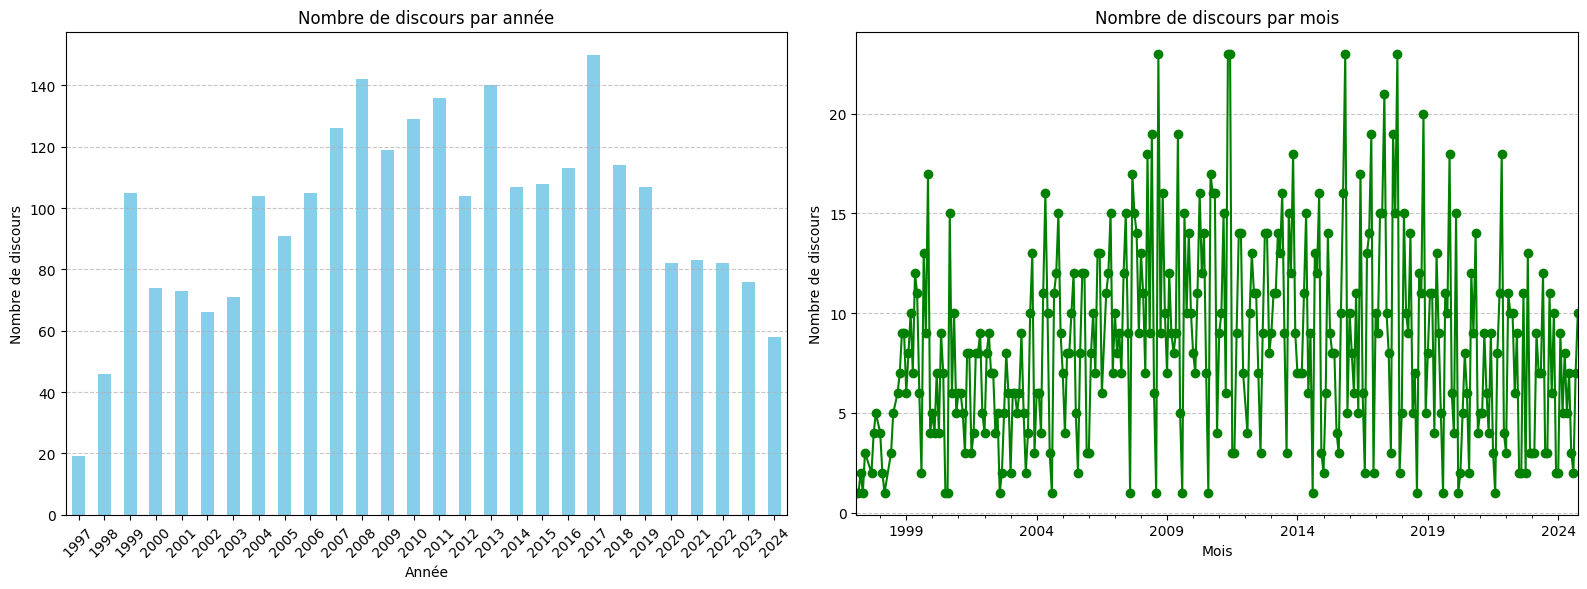

In [ ]:
# La fréquence des speechs par mois et par années
#Modifier en nombre de speechs par quarter
speeches_contents_date['date'] = pd.to_datetime(speeches_contents_date['date'])
speeches_contents_date['year'] = speeches_contents_date['date'].dt.year
speeches_contents_date['month'] = speeches_contents_date['date'].dt.month
speeches_per_year = speeches_contents_date.groupby('year').size()
speeches_contents_date['year_month'] = speeches_contents_date['date'].dt.to_period('M')
speeches_per_month = speeches_contents_date.groupby('year_month').size()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
speeches_per_year.plot(kind='bar', color='skyblue', ax=axes[0], title='Nombre de discours par année')
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Nombre de discours')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
speeches_per_month.plot(kind='line', marker='o', color='green', ax=axes[1], title='Nombre de discours par mois')
axes[1].set_xlabel('Mois')
axes[1].set_ylabel('Nombre de discours')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#II - Prédiction des discours à caractère environnemental

In [ ]:
# Les discours sous formar Numpy Array
speeches_contents=speeches_contents_date['contents'].values

In [ ]:
speeches_contents[2]

"  SPEECH  IMFC Statement    Statement by Christine Lagarde, President of the ECB, at the fiftieth meeting of the International Monetary and Financial Committee IMF Annual Meetings, 25 October 2024   Introduction  Since our last meeting in April, the global growth outlook has remained broadly unchanged. While global growth is projected to expand at a moderate pace , risks to the outlook have shifted to the downside, reflecting rising economic policy uncertainty against a backdrop of heightened geopolitical tensions. Global headline inflation continues to recede amid falling energy prices, the normalisation of supply conditions and still tight monetary policy. In October the Governing Council lowered the three key ECB interest rates by 25 basis points. The decision to lower the deposit facility rate – the rate through which it steers the monetary policy stance – reflects the Governing Council’s updated assessment of the inflation outlook, the dynamics of underlying inflation and the str

**Présentation du LLM (d'où il vient, ce qu'il fait, comment se fait le calcule du niveau de confidence...)**

In [ ]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/781 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

**La particularité de notre LLM est que ce dernier ne peut process que des textes ayant un nombre de caractères inférieur ou égale à 520. Au vu de la longueur des discours dans notre database, nous devons split les discours. Une première méthode a été de split les discours par phrases, de catégoriser les phrases puis d'utiliser le critère majoritaire pour catégoriser un discours. Nous commes conscientes que celà peut entrainer des biais, notamment le biais de perte de contexte, car une phrase isolée peut ne pas suffire à capturer l'intention ou la thématique générale du discours. Par exemple, une phrase comme "L'impact des émissions de CO2 sur l'économie est indéniable" pourrait être catégorisée comme environnementale, alors que la phrase suivante, "Cependant, les priorités actuelles restent centrées sur la stabilité monétaire", modifie le sens global en suggérant que l'environnement n'est pas une priorité.**

In [ ]:
#Eviter de tourner le code suivant qui prend plusieurs heures, le résultat est mis en csv juste après
var_factice=0


In [ ]:
if var_factice==1:

  # Connecter Google Drive
  drive.mount('/content/drive')

  # Définir le dossier où sauvegarder les fichiers dans Google Drive
  checkpoint_folder = "/content/drive/MyDrive/Checkpoints/"
  !mkdir -p $checkpoint_folder  # Créer le dossier s'il n'existe pas

  # Initialisation des variables
  final_labels = np.zeros(2730, dtype=str)
  confidence_labels = np.zeros(2730, dtype=float)
  labels = np.zeros(2730, dtype=int)

  checkpoint_interval = 100  # Sauvegarde tous les 100 itérations

  for i in range(2730):
      print(f"Processing {i+1}/{2730}")
      text = speeches_contents[i]
      chunks = text.split(".")

      results = []
      for chunk in chunks:
          if chunk.strip():
              result = nlp(chunk.strip())  # Appel à votre modèle NLP
              results.append(result)

      if results:
          labels_list = [result[0]['label'] for result in results]
          final_label = max(set(labels_list), key=labels_list.count)
          final_labels[i] = final_label
          confidence = np.mean([result[0]['score'] for result in results])
          confidence_labels[i] = confidence
      else:
          final_labels[i] = "UNKNOWN"
          confidence_labels[i] = 0.0

      labels[i] = i

      # Sauvegarde périodique
      if (i + 1) % checkpoint_interval == 0 or i == 2729:  # Tous les 100 itérations ou à la fin
          df = pd.DataFrame({
              "ID": labels[:i + 1],
              "Final Label": final_labels[:i + 1],
              "Confidence": confidence_labels[:i + 1]
          })
          partial_file = f"{checkpoint_folder}/results_checkpoint_{i+1}.csv"
          df.to_csv(partial_file, index=False)
          print(f"Checkpoint saved to Google Drive: {partial_file}")


#III-Statistiques descriptives des résultats de la catégorisation

In [179]:
speech_categ=pd.read_csv('speeches_categorized.csv',sep=';')

In [180]:
speech_categ

,ID,Final Label,Confidence
0,0,S,0.797270
1,1,N,0.827785
2,2,N,0.877081
3,3,N,0.810546
4,4,S,0.829582
...,...,...,...
2595,2695,N,0.788973
2596,2696,N,0.804228
2597,2697,N,0.714107
2598,2698,N,0.846956


In [181]:
speech_categ.isna().sum()

,0
ID,0
Final Label,0
Confidence,0


In [182]:
speech_categ['Final Label'].value_counts()

,count
Final Label,
N,1779
S,763
G,30
E,27
U,1


In [183]:
speech_categ=speech_categ.drop(speech_categ[speech_categ['Final Label']=='U'].index)

In [184]:
speeches_truncated=speeches[:2600]
speeches_truncated=speeches_truncated.reset_index(drop=True)
speeches_truncated = speeches_truncated.join(speech_categ,how='left')

In [185]:
green_speeches=speeches_truncated[speeches_truncated['Final Label']=='E']
green_speeches

,date,speakers,title,subtitle,contents,ID,Final Label,Confidence
6,2024-10-04,Frank Elderson,Sustainable finance: from “eureka!” to action,"Keynote speech by Frank Elderson, Member of th...",SPEECH Sustainable finance: from “eureka!” ...,6.0,E,0.838688
27,2024-06-07,Christine Lagarde,Central banks in a changing world: the role of...,"Speech by Christine Lagarde, President of the ...",SPEECH Central banks in a changing world: t...,27.0,E,0.871287
31,2024-05-26,Piero Cipollone,Europe’s tragedy of the horizon: the green tra...,"Speech by Piero Cipollone, Member of the Execu...",SPEECH Europe’s tragedy of the horizon: the...,31.0,E,0.864667
41,2024-04-12,Frank Elderson,“Know thyself” – avoiding policy mistakes in l...,"Keynote speech by Frank Elderson, Member of th...",SPEECH “Know thyself” – avoiding policy mis...,41.0,E,0.861139
42,2024-03-27,Frank Elderson,Taking into account climate and nature in mone...,"Remarks by Frank Elderson, Member of the Execu...",SPEECH Taking into account climate and natu...,42.0,E,0.829594
83,2023-09-05,Isabel Schnabel,What is special about climate-related and envi...,"Introductory remarks by Isabel Schnabel, Membe...",SPEECH What is special about climate-relate...,83.0,E,0.841064
111,2023-05-05,Frank Elderson,Closing gaps to bend the trend: embedding the ...,"Speech by Frank Elderson, Member of the Execut...",SPEECH Closing gaps to bend the trend: embe...,111.0,E,0.838228
114,2023-04-21,Frank Elderson,Policymakers as policy takers – accounting for...,"Speech by Frank Elderson, Member of the Execut...",SPEECH Policymakers as policy takers – acco...,114.0,E,0.840089
120,2023-03-27,Frank Elderson,Urgent and vitally important: 2023 as a key mi...,"Keynote speech by Frank Elderson, Member of th...",SPEECH Urgent and vitally important: 2023 ...,120.0,E,0.816427
136,2022-12-01,Frank Elderson,The European Climate Law and the European Cent...,"Keynote speech by Frank Elderson, Member of th...",SPEECH The European Climate Law and the Eu...,136.0,E,0.872909


In [ ]:
vectorizer = TfidfVectorizer(
 stop_words="english",
 min_df=5,
 max_df=0.8,
 ngram_range=(2,2),
 token_pattern=r"\b[a-zA-Z]{3,}\b",
 )
X_ = vectorizer.fit_transform(green_speeches['contents'].values)

In [ ]:
cols = vectorizer.get_feature_names_out()
print(len(cols))
list(cols)[:10]

363


['account climate',
 'action plan',
 'action plans',
 'address climate',
 'ambitious climate',
 'area banks',
 'arising climate',
 'asked banks',
 'asset purchase',
 'asset purchases']

In [ ]:
X_tfidf = pd.DataFrame(np.log1p(X_.toarray()), index=green_speeches.index, columns=cols)

In [ ]:
#COMMENTER
X_tfidf.mean().sort_values(ascending=False).head(30)

,0
banks supervisors,0.086201
climate risks,0.083935
environmental risks,0.081367
related environmental,0.077114
climate nature,0.076255
climate environmental,0.063981
price stability,0.063591
green transition,0.063423
euro area,0.060885
financial stability,0.058892


#IV- Mise en perspective avec les ETFs

In [167]:
data_etfs

,ETF_green_Close,ETF_fossil_Close,ETF_green_Volume,ETF_fossil_Volume,Price Spread,Return_ETF_green,Return_ETF_fossil,Return Spred,Green Speech
2008-06-25,37.889423,216.746506,2000,127800,-178.857082,NaN,NaN,NaN,0
2008-06-26,36.661625,214.811844,9800,127300,-178.150219,NaN,NaN,NaN,0
2008-06-27,36.015415,217.412552,7700,85325,-181.397137,-1.692514,0.810995,-46.659532,0
2008-06-30,36.080040,222.899490,17100,69425,-186.819450,0.104266,1.457081,-2.260762,0
2008-07-01,35.038929,225.373245,14900,144925,-190.334316,-1.887840,0.786071,-4.102723,0
...,...,...,...,...,...,...,...,...,...
2024-11-25,12.340000,146.039993,8666000,2822600,-133.699993,1.180703,-0.924076,1.731104,0
2024-11-26,12.250000,144.990005,2966700,2045300,-132.740005,-0.477781,-0.375542,-0.235774,0
2024-11-27,12.350000,145.000000,2486300,1154100,-132.650000,0.532904,0.003600,0.520587,0
2024-11-29,12.390000,145.479996,1644000,681200,-133.089995,0.211659,0.172924,0.100470,0


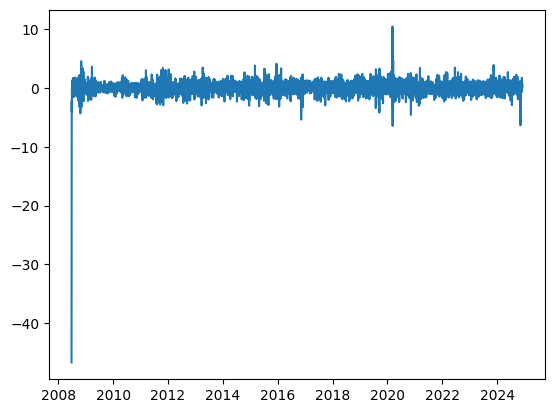

In [168]:
plt.plot(data_etfs['Return Spred'])

In [169]:
print(data_etfs['Return Spred'].describe())


count    4136.000000
mean       -0.012116
std         1.211193
min       -46.659532
25%        -0.568804
50%         0.011658
75%         0.571128
max        10.437534
Name: Return Spred, dtype: float64


In [191]:
data_etfs['Green Speech '] = data_etfs.index.isin(green_speeches['date']).astype(int)

In [163]:
data_etfs

,date,speakers,title,subtitle,contents,ID,Final Label,Confidence
6,2024-10-04,Frank Elderson,Sustainable finance: from “eureka!” to action,"Keynote speech by Frank Elderson, Member of th...",SPEECH Sustainable finance: from “eureka!” ...,6.0,E,0.838688
27,2024-06-07,Christine Lagarde,Central banks in a changing world: the role of...,"Speech by Christine Lagarde, President of the ...",SPEECH Central banks in a changing world: t...,27.0,E,0.871287
31,2024-05-26,Piero Cipollone,Europe’s tragedy of the horizon: the green tra...,"Speech by Piero Cipollone, Member of the Execu...",SPEECH Europe’s tragedy of the horizon: the...,31.0,E,0.864667
41,2024-04-12,Frank Elderson,“Know thyself” – avoiding policy mistakes in l...,"Keynote speech by Frank Elderson, Member of th...",SPEECH “Know thyself” – avoiding policy mis...,41.0,E,0.861139
42,2024-03-27,Frank Elderson,Taking into account climate and nature in mone...,"Remarks by Frank Elderson, Member of the Execu...",SPEECH Taking into account climate and natu...,42.0,E,0.829594
83,2023-09-05,Isabel Schnabel,What is special about climate-related and envi...,"Introductory remarks by Isabel Schnabel, Membe...",SPEECH What is special about climate-relate...,83.0,E,0.841064
111,2023-05-05,Frank Elderson,Closing gaps to bend the trend: embedding the ...,"Speech by Frank Elderson, Member of the Execut...",SPEECH Closing gaps to bend the trend: embe...,111.0,E,0.838228
114,2023-04-21,Frank Elderson,Policymakers as policy takers – accounting for...,"Speech by Frank Elderson, Member of the Execut...",SPEECH Policymakers as policy takers – acco...,114.0,E,0.840089
120,2023-03-27,Frank Elderson,Urgent and vitally important: 2023 as a key mi...,"Keynote speech by Frank Elderson, Member of th...",SPEECH Urgent and vitally important: 2023 ...,120.0,E,0.816427
136,2022-12-01,Frank Elderson,The European Climate Law and the European Cent...,"Keynote speech by Frank Elderson, Member of th...",SPEECH The European Climate Law and the Eu...,136.0,E,0.872909


In [192]:
data_etfs['Return Spred'][data_etfs['Green Speech '] == 1]

,Return Spred


In [ ]:
#Normaliser les returns
data_etfs['Return_ETF_green']= data_etfs['Return_ETF_green'].div(data_etfs['Return_ETF_green'].ewm(252).std())
data_etfs['Return Spred']= data_etfs['Return Spred'].div(data_etfs['Return Spred'].ewm(252).std())

In [ ]:
data_etfs['Return_ETF_fossil']= data_etfs['Return_ETF_fossil'].div(data_etfs['Return_ETF_fossil'].ewm(252).std())


In [ ]:
bins = np.linspace(-10, 10, 50)

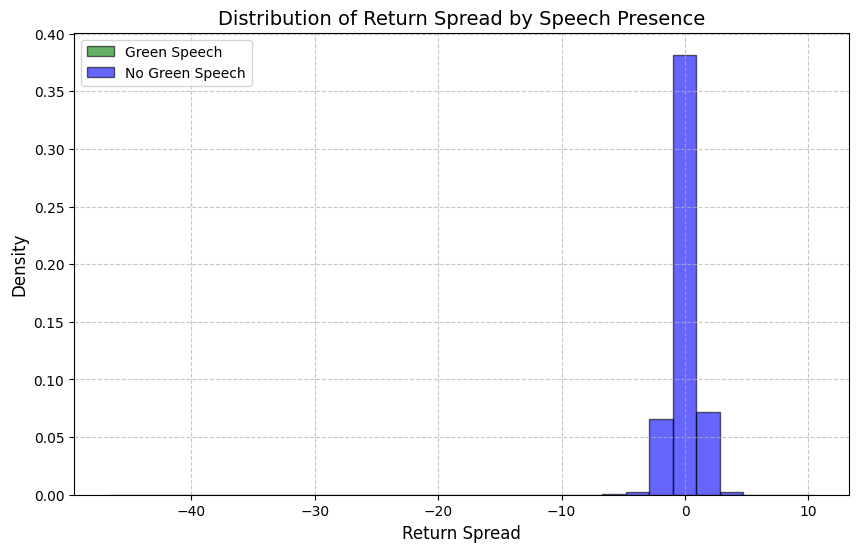

In [ ]:

# Ajuster les bins et styles pour un histogramme amélioré
plt.figure(figsize=(10, 6))

bins = 30  # Ajustez le nombre de bins

plt.hist(data_etfs['Return Spred'][data_etfs['Green Speech '] == 1],
         bins=bins,
         density=True,
         alpha=0.6,
         color='green',
         edgecolor='black',
         label='Green Speech')

plt.hist(data_etfs['Return Spred'][data_etfs['Green Speech '] == 0],
         bins=bins,
         density=True,
         alpha=0.6,
         color='blue',
         edgecolor='black',
         label='No Green Speech')

# Ajouter des titres, légendes et étiquettes
plt.title('Distribution of Return Spread by Speech Presence', fontsize=14)
plt.xlabel('Return Spread', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Afficher le plot
plt.show()


In [194]:
#Le volume avec speech et non speech

In [ ]:
data_etfs['Return_ETF_green'][data_etfs['Green Speech ']==1].mean()

,Return_ETF_green
Date,


In [ ]:
data_etfs['Return_ETF_green'][data_etfs['Green Speech ']==0].mean()

-0.006092330589805824

In [195]:
#Backtester: fait-on un plus grand profit lorsqu'on achète au même moment qu'un green speech et quon garde au long terme?

In [ ]:
#Faire les lag sharpe-ratio